```
 (This is a messy notebook) 
```

## Imports and load stuff

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pathlib import Path
from pprint import pprint
from tqdm import tqdm
import featuretools as ft
from joblib import dump, load
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV, RidgeClassifierCV, RidgeClassifier
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from  sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
import warnings
warnings.filterwarnings(
    action='ignore',
)

C:\Users\kurma\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
metadata = pd.read_csv('data/metadata.csv')
train_labels = pd.read_csv('data/train_labels.csv', index_col="sample_id")
submission_format = pd.read_csv('data/submission_format.csv')

In [4]:
metadata.groupby('split')['instrument_type'].value_counts()

split  instrument_type
test   commercial         447
       sam_testbed         64
train  commercial         754
       sam_testbed         12
val    commercial         293
Name: instrument_type, dtype: int64

In [5]:
train_df = pd.read_csv('data/train_df.csv',index_col=0,header=[0,1])
train_df.sort_index(inplace=True,axis=1)
train_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   

m/z                 99                                                   \
temp_bin  (1300, 1400] (1400, 1500]    (200, 300] (300, 400] (400, 500]   
sample_id                                                                 
S0000              0.0          0.0  2.898509e-06   0.000003   0.000000   
S0001              0.0          0.0  0.000000e+00   0.000000   0.000000   
S0002              0.0          0.0  9.257968e-07   0.000001   0.000001   
S0003              0.0          0.0  4.379099e-06   0.000006   0.000005   
S0004              0.0          0.0  3.904920e-06   0.000004   0.000004   

m/z                                                                   
temp_bin  (500, 600]    (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                             
S0000       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0001       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0002       0.000001  9.397170e-07   0.000001   0.000001    0.000001  
S0003       0.000005  4.693477e-06   0.000004   0.000004    0.000004  
S0004       0.000005  3.174421e-06   0.000004   0.000004    0.000003  

[5 rows x 1600 columns]

In [6]:
test_df = pd.read_csv('data/test_df.csv',index_col=0,header=[0,1])
test_df.sort_index(inplace=True,axis=1)
test_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0766           0.0  0.410100   0.593334     0.206508     0.000000   
S0767           0.0  0.058563   0.073878     0.088571     0.097939   
S0768           0.0  0.029256   0.040753     0.013179     0.000000   
S0769           0.0  0.000261   0.000842     0.000000     0.000000   
S0770           0.0  0.003460   0.003929     0.000467     0.000000   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0766         0.000000          0.0          0.0   0.606578   0.678006  ...   
S0767         0.063057          0.0          0.0   0.081069   0.083869  ...   
S0768         0.000000          0.0          0.0   0.037022   0.041347  ...   
S0769         0.000000          0.0          0.0   0.001313   0.001544  ...   
S0770         0.000000          0.0          0.0   0.003286   0.002893  ...   

m/z                 99                                                \
temp_bin  (1300, 1400] (1400, 1500] (200, 300] (300, 400] (400, 500]   
sample_id                                                              
S0766              0.0          0.0   0.001801   0.001626   0.001498   
S0767              0.0          0.0   0.000153   0.000187   0.000173   
S0768              0.0          0.0   0.000205   0.000122   0.000152   
S0769              0.0          0.0   0.000010   0.000010   0.000008   
S0770              0.0          0.0   0.000002   0.000002   0.000002   

m/z                                                                
temp_bin  (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                          
S0766       0.001380   0.001495   0.001755   0.001762    0.001607  
S0767       0.000150   0.000183   0.000162   0.000146    0.000133  
S0768       0.000161   0.000158   0.000182   0.000248    0.000144  
S0769       0.000009   0.000012   0.000011   0.000012    0.000000  
S0770       0.000002   0.000001   0.000003   0.000002    0.000002  

[5 rows x 1600 columns]

In [7]:
imp_fts_dict = load('l1_imp_fts_dict.joblib')
imp_fts_dict['phyllosilicate']

Int64Index([  24,  164,  202,  493,   31,  419,  136,  349,  430,  633,  111,
             360,  351,  338,  194,  207,    8,  635,  627,  173,  161,  425,
             174,  171,  426,  346,  172,  427,  170,  205,  168,  153,  991,
             348,  636,  162,  424,  145,  637,  163,  417,  428,  490,  347,
             698,  345,  369,  632,   20,  206, 1229,  337,  431,  420,  638,
             156,  429,  382,  220,  418,  175,  988,  634,  139,  160,  691,
             625,  193,  981,  491,  530,  191,   10,  702,  378,  120,  350,
             340,  165,    1,   99,  381],
           dtype='int64')

In [8]:
train_files = metadata[metadata["split"] == "train"]["features_path"].to_dict()
val_files = metadata[metadata["split"] == "val"]["features_path"].to_dict()
test_files = metadata[metadata["split"] == "test"]["features_path"].to_dict()

print("Number of training samples: ", len(train_files))
print("Number of validation samples: ", len(val_files))
print("Number of testing samples: ", len(test_files))

Number of training samples:  766
Number of validation samples:  293
Number of testing samples:  511


- multi indexing is almost similar to 2d indexing (except you use tuples for keys not headers)
- don't forget sort_index for multi index data frame (the problem arises when it is unsorted and you try to slice'em )
- for crazy things use the indexslice method..

## Let's Explore the Data Now

### Preprocessing steps

In [8]:
def drop_frac_and_He(df):
    """
    Drops fractional m/z values, m/z values > 100, and carrier gas m/z

    Args:
        df: a dataframe representing a single sample, containing m/z values

    Returns:
        The dataframe without fractional an carrier gas m/z
    """

    # drop fractional m/z values
    df = df[df["m/z"].transform(round) == df["m/z"]]
    assert df["m/z"].apply(float.is_integer).all(),   "not all m/z are integers"

    # drop m/z values greater than 99
    # df = df[df["m/z"] < 100]

    # drop carrier gas
    df = df[df["m/z"] != 4]

    return df

In [9]:
def remove_background_abundance(df):
    """
    Subtracts minimum abundance value

    Args:
        df: dataframe with 'm/z' and 'abundance' columns

    Returns:
        dataframe with minimum abundance subtracted for all observations
    """

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )

    return df

In [10]:
def scale_abun(df):
    """
    Scale abundance from 0-100 according to the min and max values across entire sample

    Args:
        df: dataframe containing abundances and m/z

    Returns:
        dataframe with additional column of scaled abundances
    """

    df["abun_minsub_scaled"] = minmax_scale(df["abundance_minsub"].astype(float))

    return df

In [12]:
# Preprocess function
def preprocess_sample(df):
    df = drop_frac_and_He(df)
    df = remove_background_abundance(df)
    df = scale_abun(df)
    return df

In [13]:
# Create a series of temperature bins
temprange = pd.interval_range(start=-100, end=2000, freq=200)
temprange

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
allcombs = list(itertools.product(temprange, [*range(0, 500)]))

allcombs_df = pd.DataFrame(allcombs, columns=["temp_bin", "m/z"])
display(allcombs_df.head())
print(allcombs_df.shape)

,temp_bin,m/z
0,"(-100, 100]",0
1,"(-100, 100]",1
2,"(-100, 100]",2
3,"(-100, 100]",3
4,"(-100, 100]",4


(5000, 2)


In [14]:
def abun_per_tempbin(df):

    """
    Transforms dataset to take the preprocessed max abundance for each
    temperature range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    """

    # Bin temperatures
    df["temp_bin"] = pd.cut(df["temp"], bins=temprange)

    # Combine with a list of all temp bin-m/z value combinations
    df = pd.merge(allcombs_df, df, on=["temp_bin", "m/z"], how="left")

    # Aggregate to temperature bin level to find max
    df = df.groupby(["temp_bin", "m/z"]).max("abun_minsub_scaled").reset_index()

    # Fill in 0 for abundance values without information
    df = df.replace(np.nan, 0)

    # Reshape so each row is a single sample
    df = df.pivot_table(columns=["m/z", "temp_bin"], values=["abun_minsub_scaled"])

    return df

In [15]:
%%time
# Assembling preprocessed and transformed training set

train_features_dict = {}
print("Total number of train files: ", len(train_files))

for i, (sample_id, filepath) in enumerate(tqdm(train_files.items())):

    # Load training sample
    temp = pd.read_csv('data/' + filepath)

    # Preprocessing training sample
    train_sample_pp = preprocess_sample(temp)

    # Feature engineering
    train_sample_fe = abun_per_tempbin(train_sample_pp).reset_index(drop=True)
    train_features_dict[sample_id] = train_sample_fe


train_features_all_mz = pd.concat(
    train_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

  0%|          | 0/766 [00:00<?, ?it/s]

Total number of train files:  766


100%|██████████| 766/766 [02:52<00:00,  4.44it/s]


Wall time: 2min 53s


In [16]:
# train_features.shape ,train_features_binned.shape,  train_features_200_binned.shape

In [175]:
train_features_all_mz

m/z               0                                                            \
temp_bin  (-100, 100] (100, 300] (300, 500] (500, 700] (700, 900] (900, 1100]   
sample_id                                                                       
0            0.004085   0.004641   0.000188   0.000000   0.000000    0.000000   
1            0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
2            0.002270   0.002495   0.000636   0.000819   0.000235    0.000086   
3            0.001336   0.002464   0.000992   0.000892   0.000631    0.000306   
4            0.005993   0.012429   0.006921   0.001966   0.000880    0.000903   
...               ...        ...        ...        ...        ...         ...   
761          0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
762          0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
763          0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
764          0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   
765          0.000000   0.000000   0.000000   0.000000   0.000000    0.000000   

m/z                                                            ...  \
temp_bin  (1100, 1300] (1300, 1500] (1500, 1700] (1700, 1900]  ...   
sample_id                                                      ...   
0                  0.0          0.0          0.0          0.0  ...   
1                  0.0          0.0          0.0          0.0  ...   
2                  0.0          0.0          0.0          0.0  ...   
3                  0.0          0.0          0.0          0.0  ...   
4                  0.0          0.0          0.0          0.0  ...   
...                ...          ...          ...          ...  ...   
761                0.0          0.0          0.0          0.0  ...   
762                0.0          0.0          0.0          0.0  ...   
763                0.0          0.0          0.0          0.0  ...   
764                0.0          0.0          0.0          0.0  ...   
765                0.0          0.0          0.0          0.0  ...   

m/z               499                                                          \
temp_bin  (-100, 100] (100, 300] (300, 500] (500, 700] (700, 900] (900, 1100]   
sample_id                                                                       
0                 0.0        0.0        0.0        0.0        0.0         0.0   
1                 0.0        0.0        0.0        0.0        0.0         0.0   
2                 0.0        0.0        0.0        0.0        0.0         0.0   
3                 0.0        0.0        0.0        0.0        0.0         0.0   
4                 0.0        0.0        0.0        0.0        0.0         0.0   
...               ...        ...        ...        ...        ...         ...   
761               0.0        0.0        0.0        0.0        0.0         0.0   
762               0.0        0.0        0.0        0.0        0.0         0.0   
763               0.0        0.0        0.0        0.0        0.0         0.0   
764               0.0        0.0        0.0        0.0        0.0         0.0   
765               0.0        0.0        0.0        0.0        0.0         0.0   

m/z                                                            
temp_bin  (1100, 1300] (1300, 1500] (1500, 1700] (1700, 1900]  
sample_id                                                      
0                  0.0          0.0          0.0          0.0  
1                  0.0          0.0          0.0          0.0  
2                  0.0          0.0          0.0          0.0  
3                  0.0          0.0          0.0          0.0  
4                  0.0          0.0          0.0          0.0  
...                ...          ...          ...          ...  
761                0.0          0.0          0.0          0.0  
762                0.0          0.0          0.0          0.0  
763                0.0          0.0          

what if no tempbins ??

In [29]:
sample_757 = pd.read_csv('data/train_features/S0757.csv')
sample_757

,time,temp,m/z,abundance
0,0.00,0.000,132.0,58.8
1,0.02,0.000,133.0,0.0
2,0.04,0.000,134.0,0.0
3,0.06,0.000,135.0,0.0
4,0.08,0.000,136.0,0.0
...,...,...,...,...
89415,2483.74,1101.676,46.0,1823.5
89416,2483.76,1101.688,47.0,2352.9
89417,2483.78,1101.700,48.0,21117.6
89418,2483.80,1101.712,49.0,176.5


In [30]:
sample_757['m/z'].describe()

count    89420.000000
mean       105.235160
std         78.058538
min          5.000000
25%         50.000000
50%         95.000000
75%        140.000000
max        433.000000
Name: m/z, dtype: float64

In [31]:
sample_757['m/z'].value_counts(normalize=True)

132.0    0.005569
162.0    0.005569
164.0    0.005569
165.0    0.005569
166.0    0.005569
           ...   
338.0    0.000313
337.0    0.000313
336.0    0.000313
335.0    0.000313
407.0    0.000313
Name: m/z, Length: 429, dtype: float64

In [37]:
sample_707.groupby(['m/z'])['abundance'].agg(['sum']).T.columns

Float64Index([ 0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0,
              11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
              22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0,
              33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0,
              44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0,
              55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0,
              66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0,
              77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0,
              88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0,
              99.0],
             dtype='float64', name='m/z')

In [235]:
metadata[(metadata["instrument_type"] == "sam_testbed") & (metadata['split'] == "train")].index

Int64Index([754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765], dtype='int64')

In [291]:
train_no_tempbins = pd.DataFrame()
train_no_tempbins

""


In [292]:
for path in tqdm(metadata.loc[:753,'features_path'].values):
    sample = pd.read_csv('data/' + path)
    sample = sample.groupby(['m/z'])['abundance'].agg(['sum']).T
    train_no_tempbins = pd.concat([train_no_tempbins,sample])

100%|██████████| 754/754 [00:16<00:00, 44.80it/s]


In [293]:
train_no_tempbins.set_index(train_df.index[:754],inplace=True)
train_no_tempbins

m/z,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,190.0,191.0,192.0,193.0,194.0,195.0,196.0,197.0,198.0,199.0
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,1.432085e-08,1.353788e-08,4.391670e-09,7.651478e-09,0.000003,3.222145e-10,6.461331e-11,4.139626e-11,3.591410e-11,2.551507e-11,...,3.952151e-12,3.982610e-12,4.041622e-12,4.175955e-12,3.839502e-12,4.067773e-12,3.997490e-12,3.571595e-12,3.597848e-12,3.935653e-12
S0001,NaN,8.743000e-08,5.562600e-06,5.688000e-07,0.000147,2.324100e-09,4.050414e-10,2.920650e-10,2.488114e-10,2.096032e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0002,8.104750e-08,1.307087e-07,3.606093e-08,6.670900e-08,0.000045,2.004619e-09,2.621438e-10,1.782477e-10,2.033837e-10,1.242948e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0003,3.522288e-08,5.544620e-08,1.806705e-08,3.548065e-08,0.000038,1.183452e-09,2.490216e-10,1.702126e-10,1.849164e-10,1.174324e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0004,1.548523e-07,2.208056e-07,7.360477e-08,1.064549e-07,0.000017,6.461538e-09,2.860305e-10,1.527094e-10,1.660491e-10,1.021598e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0749,4.140822e-08,6.558328e-08,1.940404e-08,4.216064e-08,0.000039,1.406316e-09,2.465464e-10,1.668072e-10,1.827446e-10,1.133916e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0750,2.855834e-07,4.378780e-07,1.624656e-07,2.400648e-07,0.000029,1.665118e-08,3.847777e-10,1.609611e-10,1.583387e-10,1.047151e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0751,NaN,6.545300e-08,1.033290e-05,5.303400e-07,0.000116,1.769660e-09,3.300390e-10,2.290306e-10,2.643312e-10,1.869956e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Eda

In [7]:
sorted_train_labels = train_labels.corr().unstack().sort_values(ascending=False)
sorted_train_labels.sort_index()

basalt   basalt            1.000000
         carbonate         0.451269
         chloride         -0.124137
         iron_oxide        0.252238
         oxalate          -0.074129
                             ...   
sulfide  oxychlorine       0.036961
         phyllosilicate   -0.124862
         silicate         -0.015986
         sulfate          -0.046793
         sulfide           1.000000
Length: 100, dtype: float64

In [8]:
metadata.groupby('split')['instrument_type'].value_counts()

split  instrument_type
test   commercial         447
       sam_testbed         64
train  commercial         754
       sam_testbed         12
val    commercial         293
Name: instrument_type, dtype: int64

In [9]:
for cols in train_labels.columns:
    print(cols," :", train_labels[cols].sum()/train_labels.shape[0])

# sulfide and oxalate are present just 4% of the samples

basalt  : 0.11879895561357702
carbonate  : 0.1279373368146214
chloride  : 0.12140992167101827
iron_oxide  : 0.2206266318537859
oxalate  : 0.0391644908616188
oxychlorine  : 0.2349869451697128
phyllosilicate  : 0.31723237597911225
silicate  : 0.13577023498694518
sulfate  : 0.19451697127937337
sulfide  : 0.04699738903394256


In [10]:
train_labels.columns

Index(['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate',
       'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide'],
      dtype='object')

In [11]:
dup_labels = train_labels.duplicated(keep=False) == True
train_labels[dup_labels]

#  look into the duplicated labels

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1,0
S0001,0,1,0,0,0,0,0,0,0,0
S0002,0,0,0,0,0,1,0,0,0,0
S0003,0,1,0,1,0,0,0,0,1,0
S0004,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
S0761,0,0,0,0,0,0,0,0,0,0
S0762,0,0,0,0,0,0,1,0,0,0
S0763,0,0,0,0,0,0,0,0,0,0


In [12]:
train_labels[~dup_labels]

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0091,1,1,0,0,0,1,0,1,1,0
S0159,1,0,1,0,0,0,0,0,0,0
S0250,0,0,1,1,0,0,0,1,0,0
S0563,0,0,0,0,0,0,0,0,1,1
S0610,0,0,1,0,0,0,0,0,0,1
S0755,0,1,0,0,0,0,0,0,1,0


In [134]:
mol_mass = {
    # 'basalt':,
    'carbonate':61.0168 ,
    'chloride':35.453,
    'iron_oxide':159.688,
    'oxalate':88.019,
    # 'oxychlorine': ,
    'phyllosilicate':504.190 ,
    'silicate':76.083,
    'sulfate':96.06 ,
    'sulfide':32.06 
}

# charge = {
#     'basalt':0,
#     'carbonate':0,
#     'chloride':0,
#     'iron_oxide':0,
#     'oxalate':0,
#     'oxychlorine':0,
#     'phyllosilicate':0,
#     'silicate':0,
#     'sulfate':0,
#     'sulfide':0
# }

targets = train_labels.columns.tolist()
pprint(targets)

['basalt',
 'carbonate',
 'chloride',
 'iron_oxide',
 'oxalate',
 'oxychlorine',
 'phyllosilicate',
 'silicate',
 'sulfate',
 'sulfide']


In [139]:
# for mz in range(1,100):
#     for tar in targets:
#         if tar in mol_mass.keys():
#             train_df[tar+'_z'] = 1/(mz*(1/mol_mass[tar]))
# i am a stupid

In [13]:
train_df[ ('99',  '(900, 1000]')].std()

0.013734312592763202

In [49]:
sample_707 = pd.read_csv('data/train_features/S0707.csv')
sample_456 = pd.read_csv('data/train_features/S0456.csv')
sample_320 = pd.read_csv('data/train_features/S0320.csv')
sample_279 = pd.read_csv('data/train_features/S0279.csv')
sample_707.describe()

,time,temp,m/z,abundance
count,31900.000000,31900.000000,31900.000000,3.190000e+04
mean,828.239091,506.411047,49.500000,1.290167e-09
std,479.767682,287.877305,28.866523,1.251767e-08
min,0.000000,29.805000,0.000000,1.280560e-13
25%,411.411000,255.303000,24.750000,1.979989e-13
50%,828.045000,508.451000,49.500000,2.631780e-13
75%,1245.019000,757.120000,74.250000,1.419591e-12
max,1656.756000,1000.255000,99.000000,1.273301e-07


In [183]:
sample_707['abundance'].describe()

count    3.190000e+04
mean     1.290167e-09
std      1.251767e-08
min      1.280560e-13
25%      1.979989e-13
50%      2.631780e-13
75%      1.419591e-12
max      1.273301e-07
Name: abundance, dtype: float64

In [188]:
train_labels.loc['S0707'].values

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

**ft**

In [38]:
es = ft.EntitySet(id="train_set")
es

Entityset: train_set
  DataFrames:
  Relationships:
    No relationships

In [46]:
sample_707.index.name = 'index'
sample_707.head()

,time,temp,m/z,abundance
index,,,,
0,0.0,29.805,0.0,1.189122e-10
1,0.0,29.805,1.0,1.838735e-10
2,0.0,29.805,2.0,5.178675e-11
3,0.0,29.805,3.0,1.172222e-10
4,0.0,29.805,4.0,1.261140e-07


In [55]:
es.add_dataframe(sample_707, dataframe_name="sample_707",index='index',time_index='time')
es.add_dataframe(sample_320, dataframe_name="sample_320",index='index',time_index='time')
es.add_dataframe(sample_456, dataframe_name="sample_456",index='index',time_index='time')
es.add_dataframe(sample_279, dataframe_name="sample_279",index='index',time_index='time')

Entityset: train_set
  DataFrames:
    sample_707 [Rows: 31900, Columns: 5]
    sample_320 [Rows: 31900, Columns: 5]
    sample_456 [Rows: 37200, Columns: 5]
    sample_279 [Rows: 31900, Columns: 5]
  Relationships:
    No relationships

In [56]:
es.add_dataframe(train_labels, dataframe_name="train_labels",index='sample_id')

Entityset: train_set
  DataFrames:
    sample_707 [Rows: 31900, Columns: 5]
    sample_320 [Rows: 31900, Columns: 5]
    sample_456 [Rows: 37200, Columns: 5]
    sample_279 [Rows: 31900, Columns: 5]
    train_labels [Rows: 766, Columns: 11]
  Relationships:
    No relationships

In [54]:
es.add_relationships()

Entityset: train_set
  DataFrames:
    sample_707 [Rows: 31900, Columns: 5]
    sample_320 [Rows: 31900, Columns: 5]
    sample_456 [Rows: 37200, Columns: 5]
    sample_279 [Rows: 31900, Columns: 5]
  Relationships:
    No relationships

In [59]:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name="sample_456")
feature_matrix

,time,temp,m/z,abundance
index,,,,
0,0.000,63.516,0.0,2.903510e-11
1,0.000,63.516,1.0,3.522626e-11
2,0.000,63.516,2.0,1.501926e-11
3,0.000,63.516,3.0,3.104998e-11
4,0.000,63.516,4.0,1.022021e-08
...,...,...,...,...
37195,1900.024,861.296,195.0,6.753765e-14
37196,1900.024,861.296,196.0,7.024509e-14
37197,1900.024,861.296,197.0,4.767129e-14


In [60]:
feature_defs

[<Feature: time>, <Feature: temp>, <Feature: m/z>, <Feature: abundance>]

In [62]:
750/60

12.5

**how many mzs and time intervals**

In [9]:
mz_list = []
count = 0
for path in tqdm(metadata['features_path'].values):
    mz = pd.read_csv('data/'+ path)['m/z'].max()   # this is max mz ratio observed. 
    mz_list.append(mz)

100%|██████████| 1570/1570 [00:47<00:00, 32.92it/s]


In [10]:
np.max(mz_list[:753])

199.0

In [11]:
np.array(mz_list).max()

537.0

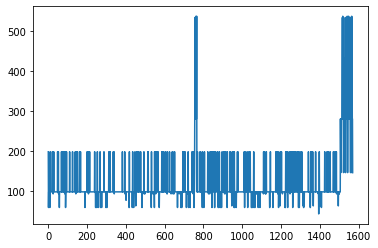

In [14]:
plt.plot(mz_list)

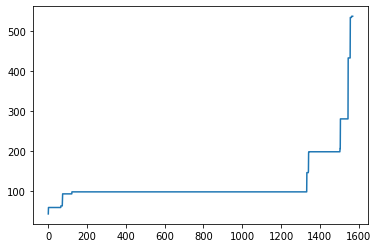

In [13]:
plt.plot(np.sort(mz_list))

In [16]:
sizes = []
count = 0
for path in tqdm(metadata['features_path'].values):
    size = pd.read_csv('data/'+ path).shape[0]   # len of each sample csv file
    sizes.append(size)


100%|██████████| 1570/1570 [00:38<00:00, 41.07it/s]


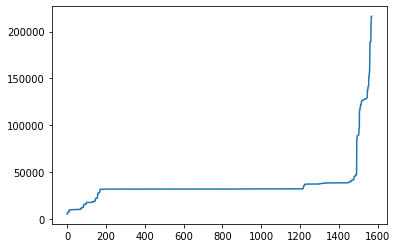

In [19]:
plt.plot(np.sort(sizes))

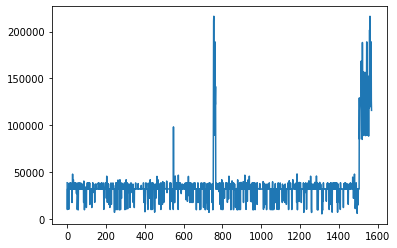

In [20]:
plt.plot(sizes)

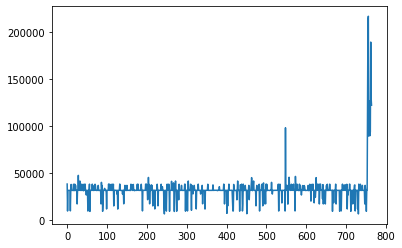

In [212]:
plt.plot(sizes[:765])

(array([ 158., 1332.,    3.,   10.,    4.,   41.,   10.,    3.,    5.,
           4.]),
 array([  5306. ,  26410.3,  47514.6,  68618.9,  89723.2, 110827.5,
        131931.8, 153036.1, 174140.4, 195244.7, 216349. ]),
 <BarContainer object of 10 artists>)

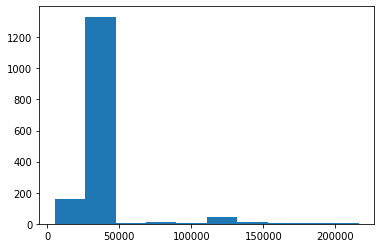

In [208]:
plt.hist(sizes, bins=10)

In [ ]:
mz_list =  []
temp_list = []
for i in train_imp_fts.columns:
    mz_list.append(i[0])
    temp_list.append(i[1])

<AxesSubplot:xlabel='sample_id'>

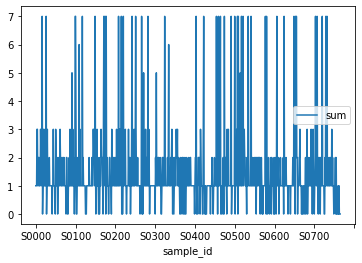

In [22]:
train_labels.agg(['sum'],axis=1).plot()

**analyze the train test data**

In [8]:
df = pd.concat([train_df,test_df],axis=0)
df

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   
...             ...       ...        ...          ...          ...   
S1565           0.0  0.000000   0.000000     0.000000          0.0   
S1566           0.0  0.000049   0.000000     0.000000          0.0   
S1567           0.0  0.000000   0.000000     0.000000          0.0   
S1568           0.0  0.000000   0.000000     0.000000          0.0   
S1569           0.0  0.000000   0.000000     0.000000          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   
...                ...          ...          ...        ...        ...  ...   
S1565              0.0          0.0          0.0   0.000000   0.000000  ...   
S1566              0.0          0.0          0.0   0.000000   0.000000  ...   
S1567              0.0          0.0          0.0   0.000000   0.000000  ...   
S1568              0.0          0.0          0.0   0.000000   0.000000  ...   
S1569              0.0          0.0          0.0   0.000000   0.000000  ...   

m/z                 99                                                   \
temp_bin  (1300, 1400] (1400, 1500]    (200, 300] (300, 400] (400, 500]   
sample_id                                                                 
S0000              0.0          0.0  2.898509e-06   0.000003   0.000000   
S0001              0.0          0.0  0.000000e+00   0.000000   0.000000   
S0002              0.0          0.0  9.257968e-07   0.000001   0.000001   
S0003              0.0          0.0  4.379099e-06   0.000006   0.000005   
S0004              0.0          0.0  3.904920e-06   0.000004   0.000004   
...                ...          ...           ...        ...        ...   
S1565              0.0          0.0  0.000000e+00   0.000000   0.000000   
S1566              0.0          0.0  4.922441e-05   0.000049   0.000000   
S1567              0.0          0.0  1.200556e-04   0.000100   0.000100   
S1568              0.0          0.0  2.444685e-04   0.000175   0.000140   
S1569              0.0          0.0  0.000000e+00   0.000000   0.000000   

m/z                                                                   
temp_bin  (500, 600]    (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                             
S0000       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0001       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0002       0.000001  9.397170e-07   0.000001   0.000001    0.000001  
S0003       0.000005  4.693477e-06   0.000004   0.000004    0.000004  
S0004       0.000005  3.174421e-06   0.000004   0.000004    0.000003  
...              ...           ...        ...        ...         ...  
S1565       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S1566       0.000049  4.922441e-05   0.000098   0.000049    0.000049  
S1567       0.000120  1.000520e-04   0.000100   0.000120    0.000080  
S1568    

In [9]:
train_labels.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1,0
S0001,0,1,0,0,0,0,0,0,0,0
S0002,0,0,0,0,0,1,0,0,0,0
S0003,0,1,0,1,0,0,0,0,1,0
S0004,0,0,0,1,0,1,1,0,0,0


In [210]:
cols = train_labels.columns
train_labels['target_vec'] =  [''.join(str(x)) for x in train_labels[cols].values]

In [211]:
train_labels.target_vec.nunique()

43

In [213]:
train_labels.target_vec.value_counts()
# may be these percentages can be used in meta modelling and prob calibration

[0 0 0 0 0 0 1 0 0 0]    109
[0 0 0 0 0 0 0 0 0 0]    102
[0 0 0 0 0 0 0 0 1 0]     54
[0 0 0 0 0 0 0 1 0 0]     44
[1 1 0 1 0 1 1 1 1 0]     43
[0 1 0 0 0 0 0 0 0 0]     39
[0 0 0 0 0 1 0 0 0 0]     39
[0 0 1 0 0 0 0 0 0 0]     37
[1 0 0 0 0 0 0 0 0 0]     34
[0 0 0 0 1 0 0 0 0 0]     30
[0 0 0 1 0 1 0 0 0 0]     30
[0 0 0 0 0 1 1 0 0 0]     29
[0 0 0 1 0 0 0 0 0 0]     22
[0 0 1 1 0 0 1 0 0 0]     20
[0 0 0 1 0 1 1 0 0 0]     17
[0 0 1 0 0 0 0 0 1 0]     17
[0 0 0 1 0 0 0 0 1 0]     13
[0 0 1 0 0 0 1 0 0 0]     13
[0 0 0 0 0 1 0 0 0 1]     11
[0 0 0 0 0 0 0 0 0 1]     10
[0 1 0 1 0 0 0 0 0 0]      5
[1 0 0 0 0 1 0 0 0 0]      4
[0 0 0 0 0 0 0 1 0 1]      4
[1 0 0 0 0 0 1 1 0 0]      3
[0 0 1 1 0 0 0 0 0 0]      3
[1 1 0 1 0 0 0 1 1 0]      3
[0 0 0 1 0 0 1 0 0 0]      3
[0 0 0 0 0 0 0 1 1 0]      3
[0 0 0 1 0 0 0 0 1 1]      3
[0 0 0 0 0 1 0 0 1 0]      2
[0 0 0 0 0 0 1 0 0 1]      2
[0 1 0 0 0 0 0 0 0 1]      2
[0 0 0 0 0 0 1 0 1 0]      2
[1 1 0 0 0 1 1 1 1 0]      2
[0 0 0 1 0 1 0

In [214]:
#  samples with only phyllosilicate are 14 % of the samples 
#  samples with none of the targets are 13 % of the samples

**how are phyllosilicate samples different from the rest ??**

In [215]:
phys_present = train_labels['phyllosilicate'] == 1
all_phys_idx = train_labels.loc[phys_present,'phyllosilicate'].index

In [216]:
all_phys_idx

Index(['S0004', 'S0006', 'S0011', 'S0012', 'S0014', 'S0016', 'S0018', 'S0023',
       'S0026', 'S0029',
       ...
       'S0728', 'S0729', 'S0731', 'S0732', 'S0733', 'S0736', 'S0743', 'S0744',
       'S0750', 'S0762'],
      dtype='object', name='sample_id', length=243)

In [217]:
only_phys = train_labels['target_vec'] == '[0 0 0 0 0 0 1 0 0 0]'
only_phys_idx = train_labels[only_phys].index

In [218]:
all_phys_df = train_df.loc[all_phys_idx]
all_phys_df

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0004           0.0  0.005993   0.012429     0.000593     0.000000   
S0006           0.0  0.135941   0.159668     0.045263     0.000000   
S0011           0.0  0.007582   0.007328     0.000000     0.000000   
S0012           0.0  0.012434   0.014042     0.001771     0.000000   
S0014           0.0  0.006278   0.007812     0.001368     0.000000   
...             ...       ...        ...          ...          ...   
S0736           0.0  0.013795   0.023513     0.011800     0.010587   
S0743           0.0  0.002268   0.003582     0.001352     0.000000   
S0744           0.0  0.013294   0.016427     0.001396     0.000000   
S0750           0.0  0.005939   0.007804     0.012092     0.000000   
S0762           0.0  0.000000   0.000000     0.000000     0.000000   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0004         0.000000          0.0          0.0   0.009380   0.005099  ...   
S0006         0.000000          0.0          0.0   0.163932   0.183625  ...   
S0011         0.000000          0.0          0.0   0.007384   0.008399  ...   
S0012         0.000000          0.0          0.0   0.018895   0.009129  ...   
S0014         0.000000          0.0          0.0   0.008283   0.013992  ...   
...                ...          ...          ...        ...        ...  ...   
S0736         0.009323          0.0          0.0   0.017304   0.014810  ...   
S0743         0.000000          0.0          0.0   0.004720   0.005613  ...   
S0744         0.000000          0.0          0.0   0.021401   0.022305  ...   
S0750         0.000000          0.0          0.0   0.006980   0.009419  ...   
S0762         0.000000          0.0          0.0   0.000000   0.000000  ...   

m/z                 99                                                \
temp_bin  (1300, 1400] (1400, 1500] (200, 300] (300, 400] (400, 500]   
sample_id                                                              
S0004              0.0          0.0   0.000004   0.000004   0.000004   
S0006              0.0          0.0   0.000865   0.001036   0.001130   
S0011              0.0          0.0   0.000076   0.000111   0.000085   
S0012              0.0          0.0   0.000017   0.000010   0.000008   
S0014              0.0          0.0   0.000004   0.000003   0.000003   
...                ...          ...        ...        ...        ...   
S0736              0.0          0.0   0.000023   0.000017   0.000025   
S0743              0.0          0.0   0.000061   0.000033   0.000024   
S0744              0.0          0.0   0.000010   0.000011   0.000013   
S0750              0.0          0.0   0.000026   0.000017   0.000022   
S0762              0.0          0.0   0.000195   0.000130   0.000260   

m/z                                                                
temp_bin  (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                          
S0004       0.000005   0.000003   0.000004   0.000004    0.000003  
S0006       0.000998   0.000908   0.001142   0.000895    0.000816  
S0011       0.000094   0.000152   0.000101   0.000123    0.000104  
S0012       0.000006   0.000009   0.000006   0.000008    0.000008  
S0014       0.000003   0.000004   0.000004   0.000004    0.000005  
...              ...        ...        ...        ...         ...  
S0736       0.000023   0.000017   0.000026   0.000016    0.000024  
S0743       0.000019   0.000021   0.000022   0.000023    0.000021  
S0744       0.000011   0.000010   0.000011   0.000009    0.000010  
S0750       0.000034   0.000024   0.000016   0.000019    0.000022  
S0762       0.00016

In [219]:
phys_df = train_df.loc[only_phys_idx]
phys_df

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0011           0.0  0.007582   0.007328     0.000000     0.000000   
S0018           0.0  0.003273   0.002890     0.002229     0.000000   
S0038           0.0  0.031529   0.038164     0.006856     0.000000   
S0047           0.0  0.001686   0.002281     0.000000     0.000000   
S0048           0.0  0.004212   0.005543     0.000000     0.000000   
...             ...       ...        ...          ...          ...   
S0733           0.0  0.005423   0.006198     0.001256     0.000000   
S0736           0.0  0.013795   0.023513     0.011800     0.010587   
S0743           0.0  0.002268   0.003582     0.001352     0.000000   
S0750           0.0  0.005939   0.007804     0.012092     0.000000   
S0762           0.0  0.000000   0.000000     0.000000     0.000000   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0011         0.000000          0.0          0.0   0.007384   0.008399  ...   
S0018         0.000000          0.0          0.0   0.002621   0.003164  ...   
S0038         0.000000          0.0          0.0   0.035636   0.037290  ...   
S0047         0.000000          0.0          0.0   0.002433   0.003509  ...   
S0048         0.000000          0.0          0.0   0.003609   0.002095  ...   
...                ...          ...          ...        ...        ...  ...   
S0733         0.000000          0.0          0.0   0.006183   0.005751  ...   
S0736         0.009323          0.0          0.0   0.017304   0.014810  ...   
S0743         0.000000          0.0          0.0   0.004720   0.005613  ...   
S0750         0.000000          0.0          0.0   0.006980   0.009419  ...   
S0762         0.000000          0.0          0.0   0.000000   0.000000  ...   

m/z                 99                                                \
temp_bin  (1300, 1400] (1400, 1500] (200, 300] (300, 400] (400, 500]   
sample_id                                                              
S0011              0.0          0.0   0.000076   0.000111   0.000085   
S0018              0.0          0.0   0.000136   0.000108   0.000076   
S0038              0.0          0.0   0.000034   0.000039   0.000036   
S0047              0.0          0.0   0.000031   0.000036   0.000048   
S0048              0.0          0.0   0.000017   0.000011   0.000013   
...                ...          ...        ...        ...        ...   
S0733              0.0          0.0   0.000018   0.000012   0.000013   
S0736              0.0          0.0   0.000023   0.000017   0.000025   
S0743              0.0          0.0   0.000061   0.000033   0.000024   
S0750              0.0          0.0   0.000026   0.000017   0.000022   
S0762              0.0          0.0   0.000195   0.000130   0.000260   

m/z                                                                
temp_bin  (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                          
S0011       0.000094   0.000152   0.000101   0.000123    0.000104  
S0018       0.000072   0.000130   0.000080   0.000086    0.000083  
S0038       0.000047   0.000038   0.000044   0.000043    0.000033  
S0047       0.000025   0.000024   0.000028   0.000025    0.000022  
S0048       0.000028   0.000009   0.000012   0.000010    0.000000  
...              ...        ...        ...        ...         ...  
S0733       0.000012   0.000017   0.000011   0.000016    0.000014  
S0736       0.000023   0.000017   0.000026   0.000016    0.000024  
S0743       0.000019   0.000021   0.000022   0.000023    0.000021  
S0750       0.000034   0.000024   0.000016   0.000019    0.000022  
S0762       0.00016

In [220]:
# # gets list of tempbins
# def get_tempbins(mz):
#     col_list = []
#     for col in train_df.columns:
#         if col[0] == str(mz):
#             col_list.append(col)
#     return col_list

In [221]:
def get_mz(mz):
    cols_list = []
    for col in train_df.columns:
        if col[0] == str(mz):
            cols_list.append(col)
    return cols_list

In [222]:
tot_abund_df = pd.DataFrame()
tot_abund_df['sample_id'] = phys_df.index
tot_abund_df.set_index('sample_id',inplace=True)

In [252]:
for i in range(100):
    mz_abund = phys_df.loc[:,get_mz(i)].sum(axis=1)
    tot_abund_df[str(i)] = mz_abund

<AxesSubplot:>

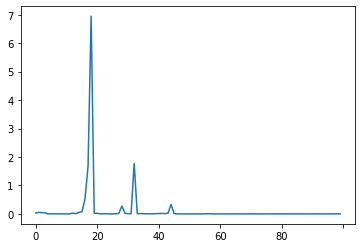

In [255]:
tot_abund_df.iloc[1,].plot()

36


<AxesSubplot:>

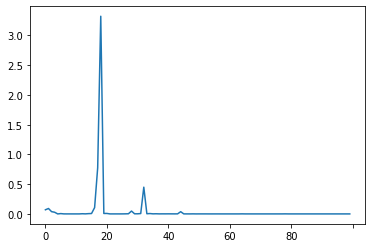

In [148]:
rand = np.random.randint(0,108)
print(rand)
tot_abund_df.iloc[rand,].plot()

In [149]:
# create a new feature if tot_abundance > something in mz around 20 (at peak) 
# or simple tot_abundance for a particular mz ratio will be a good feature i think.

In [156]:
all_phys_df_tot_abund = pd.DataFrame()
all_phys_df_tot_abund['sample_id'] = all_phys_df.index
all_phys_df_tot_abund.set_index('sample_id',inplace=True)

In [158]:
for i in range(100):
    mz_abund = all_phys_df.loc[:,get_mz(i)].sum(axis=1)  # sum row-wise across each column
    all_phys_df_tot_abund[str(i)] = mz_abund

 - OMG don't confuse summing along axis=1 is summation of all features in a row (vertical summation) right in this case.
 - summationg along axis is summing all sample values of same feature.

122


<AxesSubplot:>

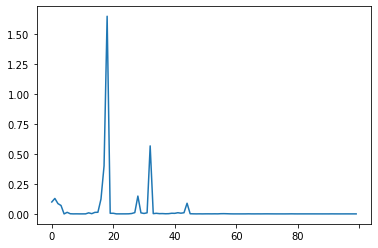

In [175]:
rand = np.random.randint(0,242)
print(rand)
all_phys_df_tot_abund.iloc[rand].plot()

In [251]:
train_df.columns.levels

FrozenList([['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'], ['(-100, 0]', '(0, 100]', '(100, 200]', '(1000, 1100]', '(1100, 1200]', '(1200, 1300]', '(1300, 1400]', '(1400, 1500]', '(200, 300]', '(300, 400]', '(400, 500]', '(500, 600]', '(600, 700]', '(700, 800]', '(800, 900]', '(900, 1000]']])

In [13]:
metadata[metadata.instrument_type == 'sam_testbed']['sample_id']

754     S0754
755     S0755
756     S0756
757     S0757
758     S0758
        ...  
1565    S1565
1566    S1566
1567    S1567
1568    S1568
1569    S1569
Name: sample_id, Length: 76, dtype: object

In [16]:
train_df['is_sam_testbed'] = 0
train_df.loc[754:,'is_sam_testbed'] = 1
train_df

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   
...             ...       ...        ...          ...          ...   
S0761           0.0  0.000000   0.000000     0.000000          0.0   
S0762           0.0  0.000000   0.000000     0.000000          0.0   
S0763           0.0  0.000000   0.000000     0.000000          0.0   
S0764           0.0  0.000000   0.000000     0.000000          0.0   
S0765           0.0  0.000000   0.000000     0.000000          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   
...                ...          ...          ...        ...        ...  ...   
S0761              0.0          0.0          0.0   0.000000   0.000000  ...   
S0762              0.0          0.0          0.0   0.000000   0.000000  ...   
S0763              0.0          0.0          0.0   0.000000   0.000000  ...   
S0764              0.0          0.0          0.0   0.000000   0.000000  ...   
S0765              0.0          0.0          0.0   0.000000   0.000000  ...   

m/z                 99                                                 \
temp_bin  (1400, 1500]    (200, 300] (300, 400] (400, 500] (500, 600]   
sample_id                                                               
S0000              0.0  2.898509e-06   0.000003   0.000000   0.000000   
S0001              0.0  0.000000e+00   0.000000   0.000000   0.000000   
S0002              0.0  9.257968e-07   0.000001   0.000001   0.000001   
S0003              0.0  4.379099e-06   0.000006   0.000005   0.000005   
S0004              0.0  3.904920e-06   0.000004   0.000004   0.000005   
...                ...           ...        ...        ...        ...   
S0761              0.0  8.563089e-05   0.000071   0.000071   0.000086   
S0762              0.0  1.947193e-04   0.000130   0.000260   0.000162   
S0763              0.0  1.838281e-04   0.000207   0.000184   0.000184   
S0764              0.0  4.167604e-04   0.000834   0.000834   0.000625   
S0765              0.0  6.860411e-05   0.000051   0.000086   0.000069   

m/z                                                       is_sam_testbed  
temp_bin     (600, 700] (700, 800] (800, 900] (900, 1000]                 
sample_id                                                                 
S0000      0.000000e+00   0.000000   0.000000    0.000000              0  
S0001      0.000000e+00   0.000000   0.000000    0.000000              0  
S0002      9.397170e-07   0.000001   0.000001    0.000001              0  
S0003      4.693477e-06   0.000004   0.000004    0.000004              0  
S0004      3.174421e-06   0.000004   0.000004    0.000003              0  
...                 ...        ...        ...         ...            ...  
S0761      7.136312e-05   0.000100   0.000086    0.000071              1  
S0762      5.193249e-04   0.000097   0.000195    0.000162              1  
S0763      2.757422e-04   0.000184   0.000184    0.000253       

In [17]:
train_df.is_sam_testbed.value_counts()

0    754
1     12
Name: is_sam_testbed, dtype: int64

### Creating new features -- tot_abund

In [180]:
def get_mz(mz):
    cols_list = []
    for col in train_df.columns:
        if col[0] == str(mz):
            cols_list.append(col)
    return cols_list

In [181]:
get_mz(3)

[('3', '(-100, 0]'),
 ('3', '(0, 100]'),
 ('3', '(100, 200]'),
 ('3', '(1000, 1100]'),
 ('3', '(1100, 1200]'),
 ('3', '(1200, 1300]'),
 ('3', '(1300, 1400]'),
 ('3', '(1400, 1500]'),
 ('3', '(200, 300]'),
 ('3', '(300, 400]'),
 ('3', '(400, 500]'),
 ('3', '(500, 600]'),
 ('3', '(600, 700]'),
 ('3', '(700, 800]'),
 ('3', '(800, 900]'),
 ('3', '(900, 1000]')]

In [259]:
train_df['tot_abund'] = train_df.sum(axis=1)   # do for test
train_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   

m/z                 99                                                 \
temp_bin  (1400, 1500]    (200, 300] (300, 400] (400, 500] (500, 600]   
sample_id                                                               
S0000              0.0  2.898509e-06   0.000003   0.000000   0.000000   
S0001              0.0  0.000000e+00   0.000000   0.000000   0.000000   
S0002              0.0  9.257968e-07   0.000001   0.000001   0.000001   
S0003              0.0  4.379099e-06   0.000006   0.000005   0.000005   
S0004              0.0  3.904920e-06   0.000004   0.000004   0.000005   

m/z                                                       tot_abund  
temp_bin     (600, 700] (700, 800] (800, 900] (900, 1000]            
sample_id                                                            
S0000      0.000000e+00   0.000000   0.000000    0.000000  3.014152  
S0001      0.000000e+00   0.000000   0.000000    0.000000  1.760583  
S0002      9.397170e-07   0.000001   0.000001    0.000001  4.175911  
S0003      4.693477e-06   0.000004   0.000004    0.000004  4.712937  
S0004      3.174421e-06   0.000004   0.000004    0.000003  4.288637  

[5 rows x 1601 columns]

In [260]:
for mz in tqdm(range(0,100)):
    train_df[f"tot_abund_{mz}"] = train_df[get_mz(mz)].sum(axis=1)

100%|██████████| 100/100 [00:01<00:00, 60.23it/s]


In [261]:
train_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   

m/z       tot_abund_90 tot_abund_91 tot_abund_92 tot_abund_93 tot_abund_94  \
temp_bin                                                                     
sample_id                                                                    
S0000         0.000013     0.000016     0.000011     0.000012     0.000015   
S0001         0.000000     0.000000     0.000000     0.000000     0.000000   
S0002         0.000011     0.000010     0.000011     0.000011     0.000010   
S0003         0.000049     0.000052     0.000053     0.000049     0.000050   
S0004         0.000048     0.000043     0.000047     0.000038     0.000048   

m/z       tot_abund_95 tot_abund_96 tot_abund_97 tot_abund_98 tot_abund_99  
temp_bin                                                                    
sample_id                                                                   
S0000         0.000012     0.000017     0.000013     0.000013     0.000013  
S0001         0.000000     0.000000     0.000000     0.000000     0.000000  
S0002         0.000010     0.000011     0.000011     0.000011     0.000011  
S0003         0.000060     0.000046     0.000051     0.000045     0.000050  
S0004         0.000043     0.000050     0.000048     0.000048     0.000045  

[5 rows x 1701 columns]

In [263]:
train_df.columns

MultiIndex([(           '0',    '(-100, 0]'),
            (           '0',     '(0, 100]'),
            (           '0',   '(100, 200]'),
            (           '0', '(1000, 1100]'),
            (           '0', '(1100, 1200]'),
            (           '0', '(1200, 1300]'),
            (           '0', '(1300, 1400]'),
            (           '0', '(1400, 1500]'),
            (           '0',   '(200, 300]'),
            (           '0',   '(300, 400]'),
            ...
            ('tot_abund_90',             ''),
            ('tot_abund_91',             ''),
            ('tot_abund_92',             ''),
            ('tot_abund_93',             ''),
            ('tot_abund_94',             ''),
            ('tot_abund_95',             ''),
            ('tot_abund_96',             ''),
            ('tot_abund_97',             ''),
            ('tot_abund_98',             ''),
            ('tot_abund_99',             '')],
           names=['m/z', 'temp_bin'], length=1701)

In [3]:
a = [0.18475842430743405,0.11231571226358872  ,0.1754628230604976 ,0.21491243907014437,0.009548251850182602,0.16578234261252128 ,0.2620440660158778 ,0.20974574459102496 ,0.17454675013777962 ,0.07994761103090736]
np.array(a).mean()
# loss without upsampling and just adding tot-abund-cols 

0.15890641649399584

In [5]:
b = [ 0.07577663346216641  , 0.0419898434986083 ,0.08308371644092631  ,0.11951283999875953,0.004385721055955345  ,0.09847862638100537 ,0.17212437697804472  ,0.09514497198085957,0.10254725158905001  ,0.02176224524797388]
np.array(b).mean()
# upsampled and added tot abund cols (10 fold cv)

0.08148062266333495

In [6]:
c = [0.07878742295536179  ,0.04523074524583713 ,0.08872348469960467  ,0.13319963021715753,0.0026662788143396194  ,0.09376803477151378  ,0.17536110938476185  ,0.11670749644665927 ,0.11547137276659762,0.02092490639971044      ]
np.array(c).mean()
# upsampled 5 fold cv

0.08708404817015437

In [7]:
d = [0.07075227207382759 ,0.03791623993423403  ,0.08137873663688354,0.12012665794269177 ,0.002320419148247345,0.0906572427852579,0.1700037641738595 ,0.11063544289313132 ,0.10142540985325714 ,0.019497954190919566]
np.array(d).mean()
# upsampled 10 fold cv

0.08047141396323097

In [8]:
e = [0.0665537138951669  ,0.03590359989212326,0.0779183204577051,0.11950424118183323 ,0.0021553265735045294 ,0.08634003283763375 ,0.1630858534297697,0.10384433599973009 ,0.09687003948068018 ,0.019960701642428788]
np.array(e).mean()
# upsampled 20 fold cv

0.07721361653905755

## Cross validate 

In [18]:
# Define stratified k-fold validation
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
# Define log loss
log_loss_scorer = make_scorer(log_loss,needs_proba=True)

In [19]:
# Check log loss score for baseline dummy model
def logloss_cross_val(clf, X, y):
    
    # Generate a score for each label class
    log_loss_cv = {}
    for col in y.columns:
        y_col = y[col]  # take one label at a time
        log_loss_cv[col] = np.mean(cross_val_score(clf, X.values, y_col, cv=skf, scoring=log_loss_scorer))
    avg_log_loss = np.mean(list(log_loss_cv.values()))

    return log_loss_cv, avg_log_loss

In [194]:
# Baseline model
# Define logistic regression model
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
#  this time cving with 1701 features (added tot abunds )
logreg_logloss = logloss_cross_val(logreg_clf, train_df, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
pprint(logreg_logloss[1])
# this might not perform that well, coz some features are not scaled

Logistic regression model log-loss:

{'basalt': 0.30278901129298175,
 'carbonate': 0.38291100989666,
 'chloride': 0.328716583226917,
 'iron_oxide': 0.37132220735417304,
 'oxalate': 0.00402137727603233,
 'oxychlorine': 0.2943876431466222,
 'phyllosilicate': 0.4347718787208382,
 'silicate': 0.3608636581799133,
 'sulfate': 0.3976859449729116,
 'sulfide': 0.16774882527417953}
Average log-loss
0.3045218139341229


In [270]:
tot_abund_cols = [cols for cols in train_df.columns if cols[0].startswith('tot_abund')]
train_df[tot_abund_cols]

m/z,tot_abund,tot_abund_0,tot_abund_1,tot_abund_2,tot_abund_3,tot_abund_4,tot_abund_5,tot_abund_6,tot_abund_7,tot_abund_8,...,tot_abund_90,tot_abund_91,tot_abund_92,tot_abund_93,tot_abund_94,tot_abund_95,tot_abund_96,tot_abund_97,tot_abund_98,tot_abund_99
temp_bin,,,,,,,,,,,...,,,,,,,,,,
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,3.014152,0.010308,0.009034,0.001326,0.000730,0.0,0.000105,0.000024,0.000019,0.000025,...,0.000013,0.000016,0.000011,0.000012,0.000015,0.000012,0.000017,0.000013,0.000013,0.000013
S0001,1.760583,0.000000,0.010812,0.120071,0.009249,0.0,0.000202,0.000175,0.000130,0.000132,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S0002,4.175911,0.009209,0.014417,0.003485,0.003207,0.0,0.000234,0.000034,0.000024,0.000041,...,0.000011,0.000010,0.000011,0.000011,0.000010,0.000010,0.000011,0.000011,0.000011,0.000011
S0003,4.712937,0.009939,0.014468,0.008389,0.007700,0.0,0.000606,0.000137,0.000108,0.000165,...,0.000049,0.000052,0.000053,0.000049,0.000050,0.000060,0.000046,0.000051,0.000045,0.000050
S0004,4.288637,0.045431,0.063083,0.022971,0.020564,0.0,0.002381,0.000208,0.000089,0.000144,...,0.000048,0.000043,0.000047,0.000038,0.000048,0.000043,0.000050,0.000048,0.000048,0.000045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0761,6.610120,0.000000,0.000000,0.000000,0.000000,0.0,0.000143,0.000300,0.000371,0.000000,...,0.000871,0.002940,0.001898,0.001584,0.001556,0.001299,0.002612,0.002084,0.001442,0.000842
S0762,10.166442,0.000000,0.000000,1.922882,0.001785,0.0,0.000000,0.000000,0.000000,0.000000,...,0.001850,0.019280,0.007984,0.006264,0.007984,0.007498,0.006297,0.009153,0.007076,0.002239


In [274]:
pd.concat([train_df.iloc[:,imp_fts_dict['basalt']],train_df[tot_abund_cols]],axis=1).head()

m/z               41          28          1                       64  \
temp_bin  (100, 200] (900, 1000] (200, 300] (1100, 1200] (900, 1000]   
sample_id                                                              
S0000       0.000031    0.000000   0.001254          0.0    0.000000   
S0001       0.000023    0.000000   0.001677          0.0    0.000000   
S0002       0.000003    0.001073   0.002742          0.0    0.000027   
S0003       0.000008    0.010228   0.001792          0.0    0.006309   
S0004       0.000045    0.001369   0.012847          0.0    0.000164   

m/z                0         44         32                          ...  \
temp_bin  (200, 300] (500, 600] (500, 600] (700, 800] (1000, 1100]  ...   
sample_id                                                           ...   
S0000       0.001394   0.000000   0.000000   0.000000     0.000000  ...   
S0001       0.000000   0.000000   0.000000   0.000000     0.000000  ...   
S0002       0.001688   0.000438   0.294738   0.060377     0.000000  ...   
S0003       0.001099   0.485557   0.004301   0.002945     0.018220  ...   
S0004       0.009380   0.004096   0.108907   0.003335     0.004313  ...   

m/z       tot_abund_90 tot_abund_91 tot_abund_92 tot_abund_93 tot_abund_94  \
temp_bin                                                                     
sample_id                                                                    
S0000         0.000013     0.000016     0.000011     0.000012     0.000015   
S0001         0.000000     0.000000     0.000000     0.000000     0.000000   
S0002         0.000011     0.000010     0.000011     0.000011     0.000010   
S0003         0.000049     0.000052     0.000053     0.000049     0.000050   
S0004         0.000048     0.000043     0.000047     0.000038     0.000048   

m/z       tot_abund_95 tot_abund_96 tot_abund_97 tot_abund_98 tot_abund_99  
temp_bin                                                                    
sample_id                                                                   
S0000         0.000012     0.000017     0.000013     0.000013     0.000013  
S0001         0.000000     0.000000     0.000000     0.000000     0.000000  
S0002         0.000010     0.000011     0.000011     0.000011     0.000011  
S0003         0.000060     0.000046     0.000051     0.000045     0.000050  
S0004         0.000043     0.000050     0.000048     0.000048     0.000045  

[5 rows x 169 columns]

In [275]:
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
for col in train_labels.columns:
    print("Target :",col)
    # sampler = SMOTETomek(random_state=RANDOM_SEED)
    # sampled_train_col = sampler.fit_resample(train_df.iloc[:,imp_fts_dict[col]], train_labels[col])
    train_set = pd.concat([train_df.iloc[:,imp_fts_dict[col]],train_df[tot_abund_cols]],axis=1)
    cb_clf = CatBoostClassifier(random_state=RANDOM_SEED,verbose=False,eval_metric='Logloss')
    cb_logloss = cross_val_score(cb_clf, train_set,train_labels[col],scoring=log_loss_scorer,cv=skf)
    print("catboost model log-loss:")
    print(cb_logloss)
    print("mean logloss --> ",cb_logloss.mean()," loss std --> ",cb_logloss.std())
    print("\n")

Target : basalt
catboost model log-loss:
[0.1671251  0.1464561  0.29325769 0.13781548 0.13678636 0.21097609
 0.19161536 0.22520733 0.18055115 0.15779358]
mean logloss -->  0.18475842430743408  loss std -->  0.04601125220082015


Target : carbonate
catboost model log-loss:
[0.06681248 0.06405699 0.09043566 0.04748098 0.11972385 0.22757573
 0.14205762 0.08219958 0.12335774 0.15945649]
mean logloss -->  0.11231571226358869  loss std -->  0.051533699564458677


Target : chloride
catboost model log-loss:
[0.17498892 0.17582352 0.14100976 0.2080621  0.26265016 0.18720684
 0.09532291 0.12451996 0.22261485 0.16242922]
mean logloss -->  0.1754628230604976  loss std -->  0.04626057214495595


Target : iron_oxide
catboost model log-loss:
[0.2820195  0.19029699 0.24339917 0.1682181  0.1515006  0.15859459
 0.26898294 0.30010423 0.19925993 0.18674835]
mean logloss -->  0.21491243907014437  loss std -->  0.05149113711135235


Target : oxalate
catboost model log-loss:
[0.00073213 0.00444142 0.00496716

KeyError: 'target_vec'

In [278]:
cv_loss = [0.18475842430743408,0.11231571226358869,0.1754628230604976,0.21491243907014437,0.0095482518501826,0.16578234261252128,0.2620440660158778,0.20974574459102496,0.17454675013777962,0.07994761103090735]
np.array(cv_loss).mean()
# this improved a bit compared to the same clf without tot_abund features

0.15890641649399584

**cv new_fts**

In [26]:
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
for col in train_labels.columns:
    print("Target :",col)
    train_set = pd.concat([train_df.iloc[:,imp_fts_dict[col]],train_df['is_sam_testbed']],axis=1)
    sampler = SMOTETomek(random_state=RANDOM_SEED)
    sampled_train_col = sampler.fit_resample(train_set, train_labels[col])
    cb_clf = CatBoostClassifier(random_state=RANDOM_SEED,verbose=False,eval_metric='Logloss')
    cb_logloss = cross_val_score(cb_clf, sampled_train_col[0],sampled_train_col[1],scoring=log_loss_scorer,cv=skf)
    print("catboost model log-loss:")
    print(cb_logloss)
    print("mean logloss --> ",cb_logloss.mean()," loss std --> ",cb_logloss.std())
    print("----------------------------------------------------------------------")

Target : basalt


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

catboost model log-loss:
[0.09685657 0.06567548 0.07193705 0.0849902  0.08272553]
mean logloss -->  0.08043696482241103  loss std -->  0.010823336176414585
----------------------------------------------------------------------
Target : carbonate
catboost model log-loss:
[0.03742015 0.07264863 0.03212216 0.04128072 0.03564184]
mean logloss -->  0.043822699692063885  loss std -->  0.014712021037697302
----------------------------------------------------------------------
Target : chloride
catboost model log-loss:
[0.07644755 0.08070176 0.06231223 0.11133726 0.11304885]
mean logloss -->  0.08876952936411811  loss std -->  0.02007833343661151
----------------------------------------------------------------------
Target : iron_oxide
catboost model log-loss:
[0.12596331 0.10845737 0.18102365 0.1461984  0.09605524]
mean logloss -->  0.13153959486213923  loss std -->  0.02995521704511196
----------------------------------------------------------------------
Target : oxalate
catboost model log-

In [27]:
is_sam_cv = [0.08043696482241103  ,0.043822699692063885  ,0.08876952936411811  ,0.13153959486213923  ,0.002701705676290964,0.09431201956532367,0.1743474032676313 ,0.11814189722369103,0.11124663756622413,0.021460946280929358]
np.array(is_sam_cv).mean()

0.08667793983208226

In [291]:
train_df[tot_abund_cols].to_csv('train_df_tot_abund.csv')

In [292]:
train_df[tot_abund_cols]

m/z,tot_abund,tot_abund_0,tot_abund_1,tot_abund_2,tot_abund_3,tot_abund_4,tot_abund_5,tot_abund_6,tot_abund_7,tot_abund_8,...,tot_abund_90,tot_abund_91,tot_abund_92,tot_abund_93,tot_abund_94,tot_abund_95,tot_abund_96,tot_abund_97,tot_abund_98,tot_abund_99
temp_bin,,,,,,,,,,,...,,,,,,,,,,
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,3.014152,0.010308,0.009034,0.001326,0.000730,0.0,0.000105,0.000024,0.000019,0.000025,...,0.000013,0.000016,0.000011,0.000012,0.000015,0.000012,0.000017,0.000013,0.000013,0.000013
S0001,1.760583,0.000000,0.010812,0.120071,0.009249,0.0,0.000202,0.000175,0.000130,0.000132,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S0002,4.175911,0.009209,0.014417,0.003485,0.003207,0.0,0.000234,0.000034,0.000024,0.000041,...,0.000011,0.000010,0.000011,0.000011,0.000010,0.000010,0.000011,0.000011,0.000011,0.000011
S0003,4.712937,0.009939,0.014468,0.008389,0.007700,0.0,0.000606,0.000137,0.000108,0.000165,...,0.000049,0.000052,0.000053,0.000049,0.000050,0.000060,0.000046,0.000051,0.000045,0.000050
S0004,4.288637,0.045431,0.063083,0.022971,0.020564,0.0,0.002381,0.000208,0.000089,0.000144,...,0.000048,0.000043,0.000047,0.000038,0.000048,0.000043,0.000050,0.000048,0.000048,0.000045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0761,6.610120,0.000000,0.000000,0.000000,0.000000,0.0,0.000143,0.000300,0.000371,0.000000,...,0.000871,0.002940,0.001898,0.001584,0.001556,0.001299,0.002612,0.002084,0.001442,0.000842
S0762,10.166442,0.000000,0.000000,1.922882,0.001785,0.0,0.000000,0.000000,0.000000,0.000000,...,0.001850,0.019280,0.007984,0.006264,0.007984,0.007498,0.006297,0.009153,0.007076,0.002239


In [293]:
df = pd.read_csv('train_df_tot_abund.csv')

In [295]:
df

,m/z,tot_abund,tot_abund_0,tot_abund_1,tot_abund_2,tot_abund_3,tot_abund_4,tot_abund_5,tot_abund_6,tot_abund_7,...,tot_abund_90,tot_abund_91,tot_abund_92,tot_abund_93,tot_abund_94,tot_abund_95,tot_abund_96,tot_abund_97,tot_abund_98,tot_abund_99
0,temp_bin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sample_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S0000,3.014152,0.010308,0.009034,0.001326,0.000730,0.0,0.000105,0.000024,0.000019,...,0.000013,0.000016,0.000011,0.000012,0.000015,0.000012,0.000017,0.000013,0.000013,0.000013
3,S0001,1.760583,0.000000,0.010812,0.120071,0.009249,0.0,0.000202,0.000175,0.000130,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,S0002,4.175911,0.009209,0.014417,0.003485,0.003207,0.0,0.000234,0.000034,0.000024,...,0.000011,0.000010,0.000011,0.000011,0.000010,0.000010,0.000011,0.000011,0.000011,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,S0761,6.610120,0.000000,0.000000,0.000000,0.000000,0.0,0.000143,0.000300,0.000371,...,0.000871,0.002940,0.001898,0.001584,0.001556,0.001299,0.002612,0.002084,0.001442,0.000842
764,S0762,10.166442,0.000000,0.000000,1.922882,0.001785,0.0,0.000000,0.000000,0.000000,...,0.001850,0.019280,0.007984,0.006264,0.007984,0.007498,0.006297,0.009153,0.007076,0.002239
765,S0763,12.480884,0.000000,0.000000,3.229343,0.001700,0.0,0.000000,0.000000,0.000000,...,0.002505,0.007744,0.004527,0.004320,0.006319,0.004320,0.005768,0.006595,0.004090,0.002367
766,S0764,20.241183,0.000000,0.000000,4.344381,0.008130,0.0,0.000000,0.000000,0.000000,...,0.008131,0.027101,0.017303,0.020013,0.018345,0.012925,0.017511,0.024391,0.013132,0.008339


### baseline cv models

In [20]:
# le = LabelEncoder()
# train_df['sample_id_encoded'] = le.fit_transform(train_df.index)
# # train_df.reset_index(drop=False,inplace=True)
# train_df.head()

In [71]:
# Baseline model
# Define logistic regression model
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
logreg_logloss = logloss_cross_val(logreg_clf, train_df, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
pprint(logreg_logloss[1])

Logistic regression model log-loss:

{'basalt': 0.26932847698554074,
 'carbonate': 0.2681950438175522,
 'chloride': 0.29349127950815757,
 'iron_oxide': 0.3771894477748686,
 'oxalate': 0.0033836488468845295,
 'oxychlorine': 0.3138217161967988,
 'phyllosilicate': 0.4103668405117268,
 'silicate': 0.3579271099724828,
 'sulfate': 0.3320723601694199,
 'sulfide': 0.1543584773679239}
Average log-loss


0.2780134401151356

In [72]:
{k: v for k, v in sorted(logreg_logloss[0].items(), key=lambda item: item[1])}
# oxalate and sulfide has lowest loss  (or were they overfitting due to small samples ??)
# phyllosilicate  has highest error

{'oxalate': 0.0033836488468845295,
 'sulfide': 0.1543584773679239,
 'carbonate': 0.2681950438175522,
 'basalt': 0.26932847698554074,
 'chloride': 0.29349127950815757,
 'oxychlorine': 0.3138217161967988,
 'sulfate': 0.3320723601694199,
 'silicate': 0.3579271099724828,
 'iron_oxide': 0.3771894477748686,
 'phyllosilicate': 0.4103668405117268}

In [176]:
# Baseline model
# Define logistic regression model
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
logreg_logloss = logloss_cross_val(logreg_clf, train_features_all_mz, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
pprint(logreg_logloss[1])

Logistic regression model log-loss:

{'basalt': 0.28280686948408174,
 'carbonate': 0.26242989412407325,
 'chloride': 0.298586407750464,
 'iron_oxide': 0.4057830226997957,
 'oxalate': 0.006159962372216957,
 'oxychlorine': 0.3010389338337914,
 'phyllosilicate': 0.4396312659446268,
 'silicate': 0.35904431735948367,
 'sulfate': 0.3093371287053941,
 'sulfide': 0.15439436322793781}
Average log-loss
0.28192121655018654


In [8]:
def something(col):
    logreg_basalt = LogisticRegression(
        penalty="l2", solver="liblinear", C=20, random_state=RANDOM_SEED, max_iter = 100, verbose = 0
    )
    basalt_cv = cross_val_score(logreg_basalt, train_df, train_labels[col], cv=skf,scoring=log_loss_scorer,)
    print(basalt_cv.mean(),basalt_cv.std())
    plt.plot(logreg_basalt.coef_.ravel(),)

0.24429625803412858 0.07391112304293858


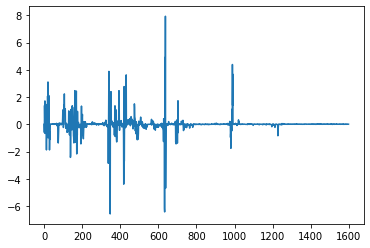

In [9]:
something('carbonate')

0.2743873181257042 0.02980642714983802


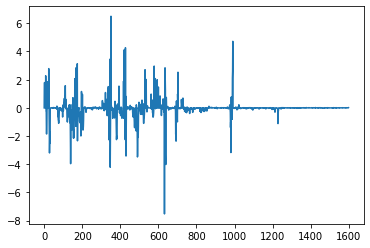

In [10]:
something('basalt')

0.12341035204584197 0.03665600165108732


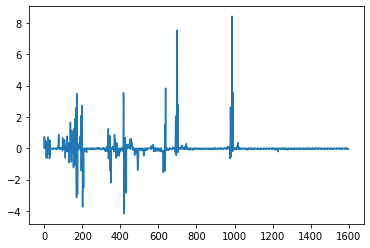

In [11]:
something('sulfide')

0.4382702008555678 0.07553018541054406


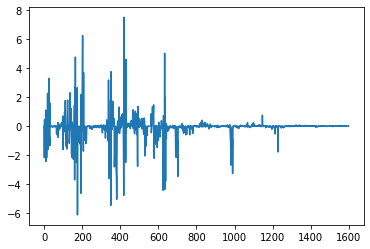

In [12]:
something('phyllosilicate')

0.0056017046841835075 0.002425247557981054


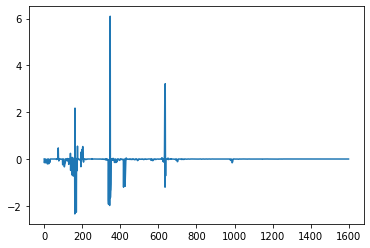

In [13]:
something('oxalate')

0.3349472074714527 0.04016880231011908


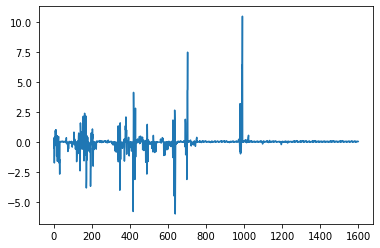

In [14]:
something('sulfate')

0.36325732092108226 0.0333402395505509


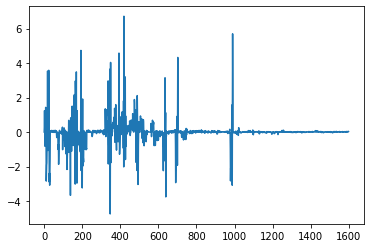

In [15]:
something('iron_oxide')

In [34]:
logreg_basalt = LogisticRegression(penalty='l1', solver='liblinear', C=20, random_state=RANDOM_SEED, verbose=0)
logreg_basalt.fit(train_df, train_labels['basalt'])

LogisticRegression(C=20, penalty='l1', random_state=777, solver='liblinear')

In [35]:
coefs = pd.Series(logreg_basalt.coef_.ravel())
coefs.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64

In [36]:
coefs.describe()

count    1600.000000
mean       -0.101289
std         3.526030
min       -77.549717
25%         0.000000
50%         0.000000
75%         0.000000
max        24.719710
dtype: float64

In [37]:
imp_fts_index = coefs.where(coefs != 0.0).dropna().sort_values(ascending=False).index
imp_fts_index

Int64Index([578, 351,  24,  20, 991,   8, 635, 427, 429, 419, 990, 167,  19,
            111, 346, 174, 420, 633, 417, 339, 171, 424, 425, 169, 164, 637,
            636, 173, 337, 627, 989, 161, 162, 168, 163, 170, 370, 345, 428,
            166, 700, 172, 418, 638, 156, 175, 344, 205, 426, 158,  31, 634,
            699, 431, 194, 348, 347, 981,  27, 430, 691, 341, 491, 632, 639,
             28, 139, 490],
           dtype='int64')

In [38]:
train_imp_fts = train_df.iloc[:,imp_fts_index]
train_imp_fts 
# these are features selected from l2 regularization.

m/z               41          28          1                       64  \
temp_bin  (100, 200] (900, 1000] (200, 300] (1100, 1200] (900, 1000]   
sample_id                                                              
S0000       0.000031    0.000000   0.001254          0.0    0.000000   
S0001       0.000023    0.000000   0.001677          0.0    0.000000   
S0002       0.000003    0.001073   0.002742          0.0    0.000027   
S0003       0.000008    0.010228   0.001792          0.0    0.006309   
S0004       0.000045    0.001369   0.012847          0.0    0.000164   
...              ...         ...        ...          ...         ...   
S0761       0.005196    0.012318   0.000000          0.0    0.001213   
S0762       0.006491    0.249107   0.000000          0.0    0.003505   
S0763       0.004917    0.041521   0.000000          0.0    0.146048   
S0764       0.012925    0.132166   0.000000          0.0    0.032312   
S0765       0.003859    0.006226   0.000000          0.0    0.001389   

m/z                0         44         32                          ...  \
temp_bin  (200, 300] (500, 600] (500, 600] (700, 800] (1000, 1100]  ...   
sample_id                                                           ...   
S0000       0.001394   0.000000   0.000000   0.000000     0.000000  ...   
S0001       0.000000   0.000000   0.000000   0.000000     0.000000  ...   
S0002       0.001688   0.000438   0.294738   0.060377     0.000000  ...   
S0003       0.001099   0.485557   0.004301   0.002945     0.018220  ...   
S0004       0.009380   0.004096   0.108907   0.003335     0.004313  ...   
...              ...        ...        ...        ...          ...  ...   
S0761       0.000000   0.026249   0.001470   0.001456     0.000999  ...   
S0762       0.000000   0.000000   0.012593   0.013859     0.012463  ...   
S0763       0.000000   0.071209   0.029963   0.024334     0.016659  ...   
S0764       0.000000   0.250573   0.081301   0.060663     0.049614  ...   
S0765       0.000000   0.012983   0.001269   0.001235     0.001303  ...   

m/z                1         32           48           28         36  \
temp_bin  (500, 600] (800, 900] (1000, 1100] (1200, 1300] (500, 600]   
sample_id                                                              
S0000       0.000000   0.000000     0.000000          0.0   0.000000   
S0001       0.000000   0.000000     0.000000          0.0   0.000000   
S0002       0.001067   0.061803     0.000000          0.0   0.001210   
S0003       0.000932   0.000614     0.005024          0.0   0.000060   
S0004       0.002220   0.003211     0.000142          0.0   0.008528   
...              ...        ...          ...          ...        ...   
S0761       0.000000   0.001270     0.000899          0.0   0.000714   
S0762       0.000000   0.018338     0.001883          0.0   0.005388   
S0763       0.000000   0.021415     0.044416          0.0   0.004458   
S0764       0.000000   0.066500     0.022722          0.0   0.008338   
S0765       0.000000   0.001132     0.000978          0.0   0.000995   

m/z               44                      1         16         36  
temp_bin  (200, 300] (900, 1000] (600, 700] (500, 600] (400, 500]  
sample_id                                                          
S0000       0.000458    0.000000   0.000000   0.000000   0.000000  
S0001       0.001406    0.000000   0.000000   0.000000   0.000022  
S0002       0.000259    0.000354   0.000195   0.040446   0.000380  
S0003       0.001415    0.001176   0.001050   0.083077   0.000038  
S0004       0.017594    0.000936   0.000697   0.017527   0.011106  
...              ...         ...        ...        ...        ...  
S0761       0.114730    0.012347   0.000000   0.008193   0.000657  
S0762       0.000000    0.000000   0.000000   0.033918   0.005355  
S0763       0.089775    0.047633   0.000000   0.025161   0.004412  
S0764       0.180113    0.131541   0.000000   0.071086   0.007088  
S0765       0.018728    0.008455   0.000000   0

0.26688889041325586 0.050806806573264605


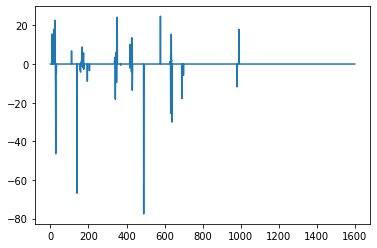

In [87]:
something('basalt')

will dts fail on train_imp_fts?

In [26]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline, Pipeline
# Define xgb  model
xgb_clf = XGBClassifier(random_state=RANDOM_SEED,eval_metric='logloss')
xgb_pipe = make_pipeline(MinMaxScaler(), xgb_clf)
print("xgb  model log-loss:\n")
xgb_logloss = logloss_cross_val(xgb_pipe, train_imp_fts, train_labels)
pprint(xgb_logloss[0])
print("Average log-loss")
xgb_logloss[1]

xgb  model log-loss:

{'basalt': 0.2080851145363473,
 'carbonate': 0.11750166153581039,
 'chloride': 0.22771708844156952,
 'iron_oxide': 0.25699716268351874,
 'oxalate': 0.020319269674338686,
 'oxychlorine': 0.19966904400419477,
 'phyllosilicate': 0.3176549768775613,
 'silicate': 0.2708447665212389,
 'sulfate': 0.2161924702844312,
 'sulfide': 0.08082980322894696}
Average log-loss


0.19158113577879576

In [ ]:
# xgb  model log-loss with fts l1 regularization:
# {'basalt': 0.2293633249345853,
#  'carbonate': 0.13192588179496223,
#  'chloride': 0.24021780412687083,
#  'iron_oxide': 0.22391952244359387,
#  'oxalate': 0.023528164902552415,
#  'oxychlorine': 0.20813601904867327,
#  'phyllosilicate': 0.29677587597469673,
#  'silicate': 0.2786606076195703,
#  'sulfate': 0.206011868818505,
#  'sulfide': 0.09018349784237223}
# Average log-loss
# 0.19287225675063824

# lgb  model log-loss:
# {'basalt': 0.3094959034706338,
#  'carbonate': 0.1577495039665277,
#  'chloride': 0.2874017974066329,
#  'iron_oxide': 0.23562215162750838,
#  'oxalate': 0.02381998197555435,
#  'oxychlorine': 0.21436703073915853,
#  'phyllosilicate': 0.30243121575368054,
#  'silicate': 0.3403485557162565,
#  'sulfate': 0.2363180162325643,
#  'sulfide': 0.14514945661919337}
# Average log-loss
# 0.22527036135077108


# catlog loss is around .16 on local machine and .15 on lb (best so far)

In [27]:
from lightgbm import LGBMClassifier
# Define lgb  model
lgb_clf = LGBMClassifier(random_state=RANDOM_SEED)
print("lgb  model log-loss:\n")
lgb_logloss = logloss_cross_val(lgb_clf, train_imp_fts, train_labels)
pprint(lgb_logloss[0])
print("Average log-loss")
lgb_logloss[1]

lgb  model log-loss:

{'basalt': 0.2669544433759584,
 'carbonate': 0.17227224642721034,
 'chloride': 0.31245690721261526,
 'iron_oxide': 0.285607610940349,
 'oxalate': 0.08667258390628632,
 'oxychlorine': 0.24321370139222473,
 'phyllosilicate': 0.33513331033385596,
 'silicate': 0.3505016897097727,
 'sulfate': 0.27739271409568084,
 'sulfide': 0.12431145213988053}
Average log-loss


0.2454516659533834

### Upsampling works ??

In [30]:
from imblearn.combine import SMOTETomek       

find imp features

In [48]:
imp_fts_dict = {}
for col in train_labels.columns:
    print("Target :",col)
    # Define stratified k-fold validation
    skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
    # Define log loss
    log_loss_scorer = make_scorer(log_loss,needs_proba=True)

    logreg_clf = LogisticRegression(penalty='l1',random_state=RANDOM_SEED,solver='liblinear',C=20)
    # check cv score for each target
    cv = cross_val_score(logreg_clf, train_df, train_labels[col], cv=skf,scoring=log_loss_scorer)
    print(cv)
    print("cv mean: ", cv.mean(), "cv std: ", cv.std())

    # collect non zero coeffs and store in imp_fts_dict
    logreg_clf.fit(train_df,train_labels[col])
    coefs = logreg_clf.coef_
    coefs = pd.Series(coefs.ravel())
    coefs = coefs.where(coefs != 0.0).dropna().sort_values(ascending=False).index
    imp_fts_dict[col] = coefs

Target : basalt
[0.28145629 0.20222666 0.36910234 0.22798772 0.21757914 0.29544072
 0.20097045 0.29409363 0.28466385 0.2953681 ]
cv mean:  0.26688889041325586 cv std:  0.050806806573264605
Target : carbonate
[0.19482698 0.41037536 0.19710714 0.17112708 0.2341675  0.64381442
 0.27073409 0.23091639 0.16539812 0.57081833]
cv mean:  0.30892854070010684 cv std:  0.16409558473395217
Target : chloride
[0.82290436 0.40821751 0.20691256 0.25194617 0.42625937 0.26595152
 0.15623535 0.23460981 0.46128416 0.27724636]
cv mean:  0.3511567163236281 cv std:  0.18398900294459541
Target : iron_oxide
[0.3648099  0.30963721 0.53064393 0.26110411 0.35804746 0.58574187
 0.39385339 0.47832248 0.44775951 0.25645293]
cv mean:  0.3986372799761864 cv std:  0.10538695097778113
Target : oxalate
[0.00043246 0.00117575 0.00161927 0.00470163 0.00081504 0.00119717
 0.0015451  0.00128765 0.00474454 0.00154794]
cv mean:  0.001906653191792414 cv std:  0.001448900402760595
Target : oxychlorine
[0.14260448 0.36150856 0.238

In [44]:
train_labels.columns

Index(['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate',
       'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide'],
      dtype='object')

In [64]:
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
for col in train_labels.columns:
    print("Target :",col)
    sampler = SMOTETomek(random_state=RANDOM_SEED)
    sampled_train_col = sampler.fit_resample(train_df.iloc[:,imp_fts_dict[col]], train_labels[col])
    cb_clf = CatBoostClassifier(random_state=RANDOM_SEED,verbose=False,eval_metric='Logloss')
    cb_logloss = cross_val_score(cb_clf, sampled_train_col[0],sampled_train_col[1],scoring=log_loss_scorer,cv=skf)
    print("catboost model log-loss:")
    print(cb_logloss)
    print("mean logloss --> ",cb_logloss.mean()," loss std --> ",cb_logloss.std())
    print("\n")

#  is this on gpu?? i think not
# note: training on gpu is losing precision leading to high error.

Target : basalt
catboost model log-loss:

[0.07088796 0.08822142 0.0713588  0.05793266 0.07604916 0.05716042
 0.06217011 0.08733612 0.07407128 0.06233481]
mean logloss -->  0.07075227207382756  loss std -->  0.010551030470167408
Target : carbonate
catboost model log-loss:

[0.03273008 0.03951086 0.07289039 0.04542207 0.03378555 0.02080151
 0.03031126 0.04369321 0.04568152 0.01433596]
mean logloss -->  0.03791623993423403  loss std -->  0.01525281192673572
Target : chloride
catboost model log-loss:

[0.06638775 0.07119081 0.06559982 0.08708901 0.06604391 0.0540795
 0.11639293 0.07652059 0.09041229 0.12007076]
mean logloss -->  0.08137873663688357  loss std -->  0.02102090247381767
Target : iron_oxide
catboost model log-loss:

[0.13322833 0.11088207 0.11328563 0.09050394 0.14810936 0.19218322
 0.14914858 0.08171027 0.07875944 0.10345573]
mean logloss -->  0.12012665794269177  loss std -->  0.03385832164344897
Target : oxalate
catboost model log-loss:

[0.00092422 0.00468864 0.0011804  0.

In [65]:
#  omg it seems like it's too good to be true... but lets see
sampled_cvs = [0.07075227207382756, 0.03791623993423403,0.08137873663688357,0.12012665794269177 ,0.0023204191482473456 ,0.09065724278525789 , 0.1700037641738595,0.11063544289313132,0.10142540985325714 ,0.019497954190919566]

In [67]:
sampled_cvs = np.array(sampled_cvs)
sampled_cvs.mean()

0.08047141396323096

In [63]:
print("mean logloss: ",cb_logloss.mean(),"loss std: ",cb_logloss.std())

mean logloss:  0.07075227207382756 loss std:  0.010551030470167408


In [ ]:
from catboost import CatBoostClassifier
# Define cb  model
cb_clf = CatBoostClassifier(random_state=RANDOM_SEED,verbose=999,eval_metric='Logloss')
print("cb  model log-loss:\n")
cb_logloss = logloss_cross_val(cb_clf, train_imp_fts, train_labels)
pprint(cb_logloss[0])
print("Average log-loss")
cb_logloss[1]

In [ ]:
# seems like gbdts are performing well on train_imp_fts 
# but how to improve further?? shall observe how imp_fts are different from other features

# i want the golden feature that should provide the biggest boost in the score

### cross validate on train_no_tempbins

In [ ]:
train_no_tempbins.fillna(0,inplace=True)
minmax_sclr = MinMaxScaler()
train_no_tempbins = minmax_sclr.fit_transform(train_no_tempbins)

In [305]:
# log reg with l2 regularization
logreg_clf = LogisticRegression(
    penalty="l2", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
# train features include sample_id
logreg_logloss = logloss_cross_val(logreg_clf, train_no_tempbins, train_labels[:754])
pprint(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

Logistic regression model log-loss:

{'basalt': 0.3367539214575674,
 'carbonate': 0.3441323894694964,
 'chloride': 0.2990165301062223,
 'iron_oxide': 0.5215518879141426,
 'oxalate': 0.13786822034861448,
 'oxychlorine': 0.4310924300522857,
 'phyllosilicate': 0.5623299947816673,
 'silicate': 0.3665243236230667,
 'sulfate': 0.3808912685053789,
 'sulfide': 0.16941994111313757}
Average log-loss


0.35495809073715795

In [90]:
# log reg with l2 regularization
logreg_clf = LogisticRegression(
    penalty="l2", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
# train features include sample_id
logreg_logloss = logloss_cross_val(logreg_clf, train_df, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

Logistic regression model log-loss:

{'basalt': 3.2461339631858515,
 'carbonate': 2.3443064429466167,
 'chloride': 3.6498495645867686,
 'iron_oxide': 5.858417326432781,
 'oxalate': 0.04485555375962525,
 'oxychlorine': 3.29453912069794,
 'phyllosilicate': 6.0909663088939,
 'silicate': 4.240053221871429,
 'sulfate': 4.5546343933836315,
 'sulfide': 1.2164170129208696}
Average log-loss


3.4540172908679416

In [61]:
# log reg with l2 regularization
logreg_clf = LogisticRegression(
    penalty="l2", solver="lbfgs", C=20, random_state=RANDOM_SEED, max_iter = 100_0, verbose = False
)
print("Logistic regression model log-loss:\n")
# train features include sample_id
logreg_logloss = logloss_cross_val(logreg_clf, train_df, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
pprint(logreg_logloss[1])

Logistic regression model log-loss:



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

{'basalt': 0.2722376836957933,
 'carbonate': 0.2334777800038636,
 'chloride': 0.27966941989266764,
 'iron_oxide': 0.359782798347852,
 'oxalate': 0.005002436476973758,
 'oxychlorine': 0.28914523986590485,
 'phyllosilicate': 0.4199491793975046,
 'silicate': 0.3331575705962414,
 'sulfate': 0.32691185201988354,
 'sulfide': 0.14065204039307266}
Average log-loss
0.26599860006897574


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [65]:
%%time
# logistic regression with elasticnet regularization
logreg_clf = LogisticRegression(
    penalty="elasticnet", solver="saga", C=20, random_state=RANDOM_SEED,l1_ratio=0.75, max_iter = 10_000, verbose = 0
)

# logreg_clf.fit(train_df,train_labels['basalt'])
stratify = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score = cross_val_score(logreg_clf,train_df.values,train_labels['basalt'],scoring='neg_log_loss',cv= stratify)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 3533 epochs took 60 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 3742 epochs took 136 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 4114 epochs took 147 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 1965 epochs took 42 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 4119 epochs took 139 seconds
Wall time: 8min 44s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


In [67]:
score.mean()

-0.27768909784585993

In [ ]:
# 0.2974150175597393
# 0.27768909784585993 elastic net
# 

In [80]:
# logistic regression model on 200_binned data
print(train_features_200_binned.shape)
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
# train features include sample_id
logreg_logloss = logloss_cross_val(logreg_clf, train_features_200_binned, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

(766, 1000)
Logistic regression model log-loss:

{'basalt': 0.2827991825395489,
 'carbonate': 0.2622501704518315,
 'chloride': 0.29862403676626886,
 'iron_oxide': 0.4057920658573229,
 'oxalate': 0.006167013809661587,
 'oxychlorine': 0.30100544470106266,
 'phyllosilicate': 0.4395374964249781,
 'silicate': 0.3590782050906852,
 'sulfate': 0.3094363871687566,
 'sulfide': 0.15437548677535956}
Average log-loss


0.2819065489585476

In [68]:
# logistic regression model on binned data
print(train_features.shape)
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
# train features include sample_id
logreg_logloss = logloss_cross_val(logreg_clf, train_features, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

(766, 4000)
Logistic regression model log-loss:

{'basalt': 0.2958038284105077,
 'carbonate': 0.27446724818289936,
 'chloride': 0.26734018488851097,
 'iron_oxide': 0.38555513423006343,
 'oxalate': 0.01176901112530861,
 'oxychlorine': 0.3312958234722928,
 'phyllosilicate': 0.42069440756802995,
 'silicate': 0.3432853487264241,
 'sulfate': 0.30733841409701673,
 'sulfide': 0.13703382647947718}
Average log-loss


0.27745832271805304

In [76]:
# logistic regression model on more binned data
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
# train features include sample_id
logreg_logloss = logloss_cross_val(logreg_clf, train_features_binned, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

Logistic regression model log-loss:

{'basalt': 0.2743116193392846,
 'carbonate': 0.2739140455310597,
 'chloride': 0.27769880425833227,
 'iron_oxide': 0.3934946425270659,
 'oxalate': 0.01728277768743889,
 'oxychlorine': 0.3739454088784326,
 'phyllosilicate': 0.4399374876587756,
 'silicate': 0.32840845017734777,
 'sulfate': 0.35488659494472097,
 'sulfide': 0.1868519587699174}
Average log-loss


0.2920731789772376

In [63]:
pca = PCA(n_components=750,random_state=RANDOM_SEED)
pca_trained = pca.fit_transform(train_df)

C:\Users\kurma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [149]:
tsne = TSNE(n_components=3, random_state=RANDOM_SEED)
tsne_trained = tsne.fit_transform(train_df.drop('sample_id_encoded',axis=1).values)

C:\Users\kurma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kurma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [136]:
pca_trained.shape,tsne_trained.shape

((766, 700), (766, 3))

In [137]:
# logistic regression on tsne transformed data
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
logreg_logloss = logloss_cross_val(logreg_clf,tsne_trained, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

Logistic regression model log-loss:

{'basalt': 0.3617159846432222,
 'carbonate': 0.3728534894648779,
 'chloride': 0.3513597859309511,
 'iron_oxide': 0.4834823907787708,
 'oxalate': 0.06403883425572789,
 'oxychlorine': 0.47733667135201135,
 'phyllosilicate': 0.6268637113287563,
 'silicate': 0.3945945952284848,
 'sulfate': 0.4424766409531397,
 'sulfide': 0.19046191883348018}
Average log-loss


0.3765184022769422

In [66]:
# logistic regression on pca transformed data
logreg_clf = LogisticRegression(
    penalty="l1", solver="liblinear", C=10, random_state=RANDOM_SEED
)
print("Logistic regression model log-loss:\n")
logreg_logloss = logloss_cross_val(logreg_clf,pca_trained, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

Logistic regression model log-loss:

{'basalt': 0.3008332137913802,
 'carbonate': 0.28562709910916095,
 'chloride': 0.2633569661891945,
 'iron_oxide': 0.3762556667261534,
 'oxalate': 0.004042972629294361,
 'oxychlorine': 0.310686701910554,
 'phyllosilicate': 0.46191910411308834,
 'silicate': 0.35950347483842243,
 'sulfate': 0.35841150394510957,
 'sulfide': 0.14336145561713312}
Average log-loss


0.28639981588694907

In [71]:
# ridge classification
ridge_clf = RidgeClassifier(0.4, random_state=RANDOM_SEED)
print("ridge classification model log-loss:\n")
ridge_logloss = logloss_cross_val(ridge_clf,train_df, train_labels)
pprint(ridge_logloss[0])
print("Average log-loss")
ridge_logloss[1]

ridge classification model log-loss:

{'basalt': 3.8316106953959257,
 'carbonate': 2.974646052638505,
 'chloride': 3.5164528872441663,
 'iron_oxide': 5.545605785101194,
 'oxalate': 0.1357481226902194,
 'oxychlorine': 3.971501769135324,
 'phyllosilicate': 6.134049144485565,
 'silicate': 4.960682666262222,
 'sulfate': 5.141288446915828,
 'sulfide': 1.5776222752804523}
Average log-loss


3.7789207845149404

### knn at 0.3

In [150]:
from sklearn.neighbors import KNeighborsClassifier
# Define KNeighborsClassifier model
knn_clf = KNeighborsClassifier(n_neighbors=33)
print("KNeighborsClassifier model log-loss:\n")
logreg_logloss = logloss_cross_val(knn_clf, pd.DataFrame(pca_trained), train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

KNeighborsClassifier model log-loss:

{'basalt': 0.32259223288324046,
 'carbonate': 0.23867501700895902,
 'chloride': 0.2896943695192836,
 'iron_oxide': 0.3889438108550601,
 'oxalate': 0.04698203123877648,
 'oxychlorine': 0.3334901330100087,
 'phyllosilicate': 0.49917826600887977,
 'silicate': 0.3515587994293642,
 'sulfate': 0.3621776194441326,
 'sulfide': 0.23630683308735584}
Average log-loss


0.3069599112485061

In [61]:
def knee_locator(r):
    l = []
    k_s = []
    for i in tqdm(r):
        knn_clf = KNeighborsClassifier(n_neighbors=int(i))
        loss = logloss_cross_val(knn_clf, train_df, train_labels)
        l.append(loss[1])
        k_s.append(i)
    print( k_s[np.argmin(l)])
    plt.plot(k_s, l,label=['k'])
    plt.xlabel('kneighbors')
    plt.ylabel('logloss')
    plt.legend()
    plt.show()

100%|██████████| 96/96 [03:34<00:00,  2.24s/it]

33


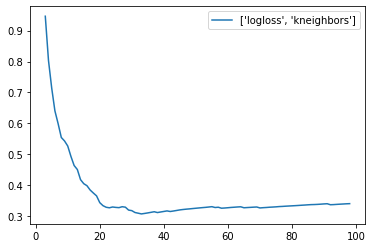

In [63]:
knee_locator(range(3,99))

In [129]:
from sklearn.neighbors import KNeighborsClassifier
# Define KNeighborsClassifier model
knn_clf = KNeighborsClassifier(n_neighbors=33)
print("KNeighborsClassifier model log-loss:\n")
logreg_logloss = logloss_cross_val(knn_clf,train_imp_fts, train_labels)
pprint(logreg_logloss[0])
print("Average log-loss")
logreg_logloss[1]

KNeighborsClassifier model log-loss:

{'basalt': 0.3204824528914433,
 'carbonate': 0.23357263908763276,
 'chloride': 0.2876880157114259,
 'iron_oxide': 0.3835538119003091,
 'oxalate': 0.04204802950555841,
 'oxychlorine': 0.32659359066854254,
 'phyllosilicate': 0.5037799054198369,
 'silicate': 0.31056081603179786,
 'sulfate': 0.36121492967049795,
 'sulfide': 0.24082025796558176}
Average log-loss


0.3010314448852626

In [132]:
train_labels['phyllosilicate']

0    523
1    243
Name: phyllosilicate, dtype: int64

# Make Submissions

In [65]:
all_test_files = val_files.copy()
all_test_files.update(test_files)
print("Total test files: ", len(all_test_files))

Total test files:  804


In [66]:
# Import submission format
submission_template_df = submission_format.copy(deep=True)
compounds_order = submission_template_df.columns
sample_order = submission_template_df.index

In [83]:
def drop_frac_and_He_test(df):
    """
    Drops fractional m/z values, m/z values > 100, and carrier gas m/z

    Args:
        df: a dataframe representing a single sample, containing m/z values

    Returns:
        The dataframe without fractional an carrier gas m/z
    """

    # drop fractional m/z values
    df = df[df["m/z"].transform(round) == df["m/z"]]
    assert df["m/z"].apply(float.is_integer).all(), "not all m/z are integers"

    # drop m/z values greater than 99
    df = df[df["m/z"] < 100]

    # drop carrier gas
    df = df[df["m/z"] != 4]

    return df

In [84]:
def remove_background_abundance_test(df):
    """
    Subtracts minimum abundance value

    Args:
        df: dataframe with 'm/z' and 'abundance' columns

    Returns:
        dataframe with minimum abundance subtracted for all observations
    """

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )

    return df

In [85]:
def scale_abun_test(df):
    """
    Scale abundance from 0-100 according to the min and max values across entire sample

    Args:
        df: dataframe containing abundances and m/z

    Returns:
        dataframe with additional column of scaled abundances
    """

    df["abun_minsub_scaled"] = minmax_scale(df["abundance_minsub"].astype(float))

    return df

In [86]:
# Preprocess function
def preprocess_sample_test(df):
    df = drop_frac_and_He_test(df)
    df = remove_background_abundance_test(df)
    df = scale_abun_test(df)
    return df

In [87]:
# Create a series of temperature bins
temprange_test = pd.interval_range(start=-100, end=1500, freq=100)
temprange_test

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
allcombs_test = list(itertools.product(temprange, [*range(0, 100)]))

allcombs_df_test = pd.DataFrame(allcombs, columns=["temp_bin", "m/z"])
allcombs_df_test.head()

,temp_bin,m/z
0,"(-100, 100]",0
1,"(-100, 100]",1
2,"(-100, 100]",2
3,"(-100, 100]",3
4,"(-100, 100]",4


In [88]:

def abun_per_tempbin_test(df):

    """
    Transforms dataset to take the preprocessed max abundance for each
    temperature range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    """

    # Bin temperatures
    df["temp_bin"] = pd.cut(df["temp"], bins=temprange_test)

    # Combine with a list of all temp bin-m/z value combinations
    df = pd.merge(allcombs_df, df, on=["temp_bin", "m/z"], how="left")

    # Aggregate to temperature bin level to find max
    df = df.groupby(["temp_bin", "m/z"]).max("abun_minsub_scaled").reset_index()

    # Fill in 0 for abundance values without information
    df = df.replace(np.nan, 0)

    # Reshape so each row is a single sample
    df = df.pivot_table(columns=["m/z", "temp_bin"], values=["abun_minsub_scaled"])

    return df

In [89]:
%%time
# Assembling preprocessed and transformed testing set

test_feat_dict = {}
print("Total number of test files: ", len(all_test_files))

for i, (sample_id, filepath) in enumerate(tqdm(all_test_files.items())):

    # Load testing sample
    temp = pd.read_csv('data/' + filepath)

    # Preprocessing testing sample
    test_sample_pp = preprocess_sample_test(temp)

    # Feature engineering
    test_sample_fe = abun_per_tempbin_test(test_sample_pp).reset_index(drop=True)
    test_feat_dict[sample_id] = test_sample_fe


test_features = pd.concat(
    test_feat_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

  0%|          | 0/804 [00:00<?, ?it/s]

Total number of test files:  804


100%|██████████| 804/804 [03:02<00:00,  4.40it/s]


Wall time: 3min 3s


In [ ]:
# imp_fts_index = [578, 351,  24,  20, 991,   8, 635, 427, 429, 419, 990, 167,  19,
#             111, 346, 174, 420, 633, 417, 339, 171, 424, 425, 169, 164, 637,
#             636, 173, 337, 627, 989, 161, 162, 168, 163, 170, 370, 345, 428,
#             166, 700, 172, 418, 638, 156, 175, 344, 205, 426, 158,  31, 634,
#             699, 431, 194, 348, 347, 981,  27, 430, 691, 341, 491, 632, 639,
#              28, 139, 490]

In [ ]:
imp_fts_index